In [1]:
!pip install imbalanced-learn


Before SMOTE: Counter({3: 30089, 1: 19212, 2: 2596, 0: 1662})
After SMOTE: Counter({1: 30089, 3: 30089, 2: 30089, 0: 30089})
Fitting 4 folds for each of 3 candidates, totalling 12 fits


c:\Users\AhmedFahmy\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:48:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'reg_lambda': 1.0, 'subsample': 0.6}

Cross-validation F1 scores: [0.9251309  0.92591815 0.92610809 0.92870299]
Mean CV score: 0.9265

📊 Validation Classification Report:
              precision    recall  f1-score   support

         AFM       0.52      0.33      0.41       554
          FM       0.82      0.90      0.86      6404
         FiM       0.51      0.35      0.41       865
          NM       0.97      0.96      0.96     10031

    accuracy                           0.89     17854
   macro avg       0.71      0.63      0.66     17854
weighted avg       0.88      0.89      0.88     17854



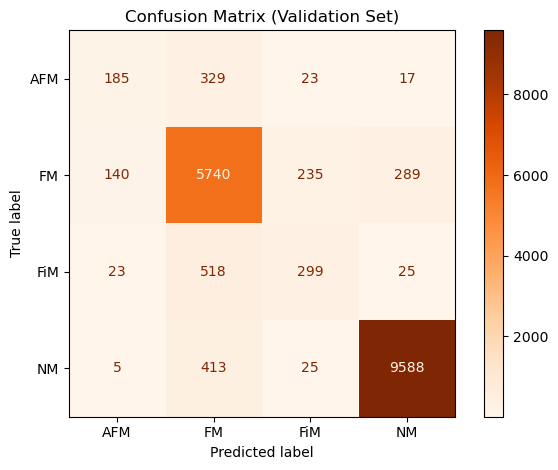

In [1]:
#  XGBoost training pipeline with SMOTE integration

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

# === 1. Load CSV ===
df = pd.read_csv("All Data Imported.csv")

# === 2. Parse elements column ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system from symmetry column ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Split data ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 10. Apply SMOTE to training data ===
print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_smote))

# === 11. Setup CV and Grid Search ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'learning_rate': [0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [1.0],
    'reg_lambda': [1.0]
}
grid_search = GridSearchCV(
    XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# === 12. Fit on SMOTE-augmented training set ===
grid_search.fit(X_train_smote, y_train_smote)
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 13. Cross-validation scores on training set ===
cv_scores = cross_val_score(best_clf, X_train_smote, y_train_smote, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# === 14. Evaluate on validation set ===
print("\n📊 Validation Classification Report:")
y_pred_val = best_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()


In [4]:
import shap

# Use TreeExplainer (optimized for XGBoost)
explainer = shap.TreeExplainer(best_clf)

# Use original (non-SMOTE) features for interpretability
X_shap = X_train  # Or use X_val for global explanation on validation set

# Compute SHAP values
shap_values = explainer.shap_values(X_shap)


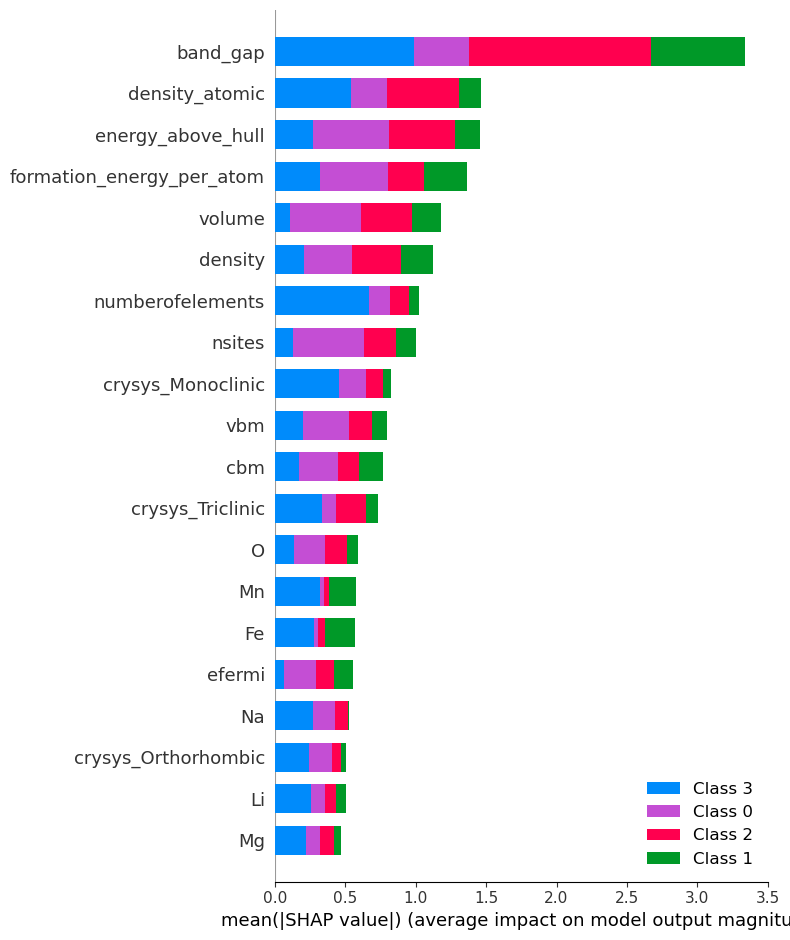

In [5]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=True)


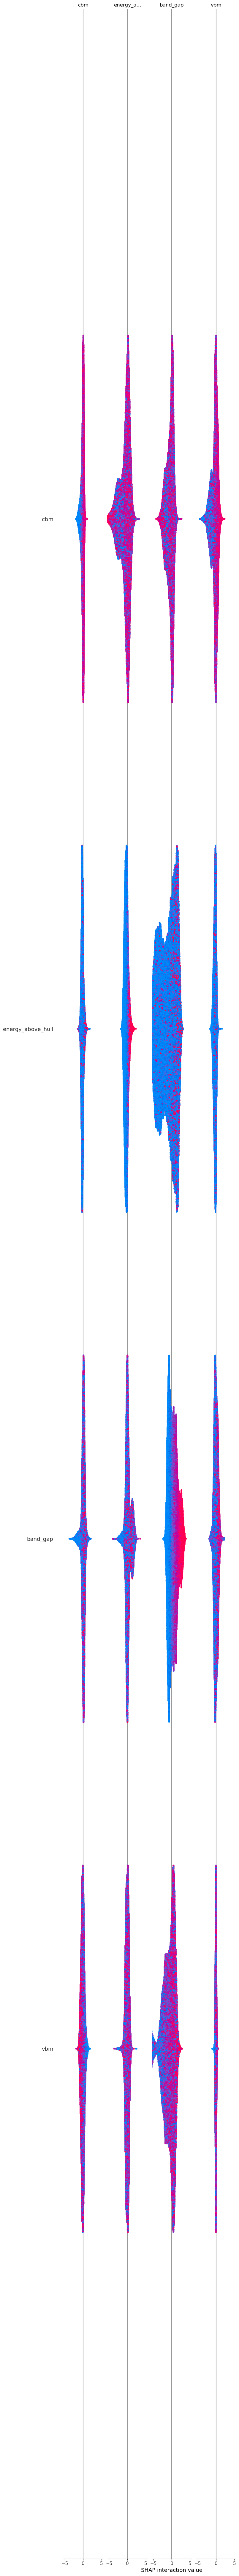

In [7]:
shap_values = explainer.shap_values(X_shap)  # no "_interaction_"
shap.summary_plot(shap_values, X_shap, show=True, max_display=X_shap.shape[1])
